<a href="https://colab.research.google.com/github/2024S-Ajou-ML-pandastic4/whaccent/blob/master/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install datasets torchaudio pandas openpyxl torch tqdm

import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.cuda.amp as amp
import gc
from datasets import load_dataset, DatasetDict, Audio
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux

In [ ]:
import torchaudio
from datasets import load_dataset, DatasetDict, Audio
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from google.colab import files
import numpy as np

# 데이터셋 로드
dataset_name = "iisking/waccent"
dataset = DatasetDict()

dataset["train"] = load_dataset(dataset_name, split="train")
dataset["validation"] = load_dataset(dataset_name, split="validatoin")  # 데이터셋의 오타를 반영
dataset["test"] = load_dataset(dataset_name, split="test")

# 오디오 데이터셋으로 변환 및 리샘플링
def resample_audio(batch):
    audio = torch.tensor(batch["filename"]["array"], dtype=torch.float32)
    resampled_audio = torchaudio.transforms.Resample(orig_freq=48000, new_freq=16000)(audio)
    batch["filename"] = resampled_audio.numpy()
    return batch

dataset = dataset.map(resample_audio)

# 멜 스펙트럼 변환 함수
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=400,
    win_length=400,
    hop_length=160,
    n_mels=64
)

def log_mel_spectrogram_transform(batch):
    audio = torch.tensor(batch["filename"], dtype=torch.float32)
    mel_spec = mel_transform(audio)
    log_mel_spec = torch.log(mel_spec + 1e-9)  # 로그 변환
    batch["log_mel_spectrogram"] = log_mel_spec.numpy()
    return batch

dataset = dataset.map(log_mel_spectrogram_transform)

# 라벨을 숫자로 변환하기 위한 맵핑 (지정된 순서대로 라벨을 설정)
accent_list = ['australia', 'us', 'england', 'canada', 'indian', 'KR']
accent_to_label = {accent: idx for idx, accent in enumerate(accent_list)}

class CustomDataset(Dataset):
    def __init__(self, hf_dataset, accent_to_label, max_length=1000): # max_length를 1000으로 설정
        self.dataset = hf_dataset
        self.accent_to_label = accent_to_label
        self.max_length = max_length  # 최대 길이를 설정

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        log_mel_spec = item["log_mel_spectrogram"]
        accent = item["accent"]

        # 로그 멜 스펙트럼 데이터를 텐서로 변환
        log_mel_spec = torch.tensor(log_mel_spec, dtype=torch.float32)  # float32로 변환하여 데이터 타입 일관성 유지

        # 라벨을 숫자로 변환
        label = self.accent_to_label[accent]

        # 로그 멜 스펙트럼 길이를 max_length로 패딩 또는 잘라내기
        if log_mel_spec.shape[1] > self.max_length:
            log_mel_spec = log_mel_spec[:, :self.max_length]
        else:
            pad_size = self.max_length - log_mel_spec.shape[1]
            log_mel_spec = torch.nn.functional.pad(log_mel_spec, (0, pad_size))

        return log_mel_spec, label

def collate_fn(batch):
    # 배치의 로그 멜 스펙트럼과 라벨을 각각 분리
    log_mel_specs, labels = zip(*batch)
    # 로그 멜 스펙트럼 시퀀스를 패딩하여 텐서로 변환
    log_mel_specs = pad_sequence(log_mel_specs, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)  # long 타입으로 변환
    return log_mel_specs, labels

# 데이터셋 및 데이터로더 생성
batch_size = 1  # 배치 크기를 더 줄입니다.

train_dataset = CustomDataset(dataset["train"], accent_to_label)
val_dataset = CustomDataset(dataset["validation"], accent_to_label)
test_dataset = CustomDataset(dataset["test"], accent_to_label)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# 데이터 로더 테스트
for log_mel_spec, label in train_loader:
    print(log_mel_spec.shape, label.shape)
    break


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating validatoin split:   0%|          | 0/3618 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1782 [00:00<?, ? examples/s]

Map:   0%|          | 0/12600 [00:00<?, ? examples/s]

Map:   0%|          | 0/3618 [00:00<?, ? examples/s]

Map:   0%|          | 0/1782 [00:00<?, ? examples/s]

Map:   0%|          | 0/12600 [00:00<?, ? examples/s]

Map:   0%|          | 0/3618 [00:00<?, ? examples/s]

Map:   0%|          | 0/1782 [00:00<?, ? examples/s]

torch.Size([1, 64, 1000]) torch.Size([1])


In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.cuda.amp as amp
import gc

# RNN 모델 정의
class AccentRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AccentRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)  # [batch_size, max_length, n_mels] -> [batch_size, n_mels, max_length]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 하이퍼파라미터 설정
input_size = 64  # 로그 멜 스펙트럼의 시간 길이에 맞춥니다.
hidden_size = 64
num_layers = 2
num_classes = len(accent_to_label)
num_epochs = 10
learning_rate = 0.0001
accumulation_steps = 4

model = AccentRNN(input_size, hidden_size, num_layers, num_classes).to('cuda')

# 데이터 불균형 문제를 해결하기 위해 가중치를 부여합니다.
class_counts = np.bincount([accent_to_label[label] for label in dataset['train']['accent']])
class_weights = 1. / class_counts
weights = [class_weights[accent_to_label[label]] for label in dataset['train']['accent']]
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to('cuda'))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Mixed Precision Training을 위한 Scaler 설정
scaler = amp.GradScaler()

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    optimizer.zero_grad()

    for i, (log_mel_specs, labels) in enumerate(loop):
        log_mel_specs = log_mel_specs.to('cuda').float()  # float32로 변환하여 데이터 타입 일관성 유지
        labels = labels.to('cuda').long()  # labels를 long 타입으로 변환

        # Mixed Precision Training 사용
        with amp.autocast():
            outputs = model(log_mel_specs)
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps  # Gradient Accumulation

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())

    # 에폭마다 GPU 캐시 비우기 및 가비지 컬렉션
    torch.cuda.empty_cache()
    gc.collect()

    # 에폭마다 GPU 메모리 사용량 확인
    if torch.cuda.is_available():
        print(f"Epoch {epoch+1}/{num_epochs}]")
        print("사용 중인 GPU 메모리 (MB):", torch.cuda.memory_allocated() / 1024 ** 2)
        print("예약된 GPU 메모리 (MB):", torch.cuda.memory_reserved() / 1024 ** 2)

# 모델 저장
torch.save(model.state_dict(), '/content/accent_rnn_model.pth')


Epoch [1/10]: 100%|██████████| 12600/12600 [10:26<00:00, 20.13it/s, loss=0.451]


Epoch 1/10]
사용 중인 GPU 메모리 (MB): 18.6796875
예약된 GPU 메모리 (MB): 44.0


Epoch [2/10]: 100%|██████████| 12600/12600 [10:23<00:00, 20.20it/s, loss=0.457]


Epoch 2/10]
사용 중인 GPU 메모리 (MB): 18.92529296875
예약된 GPU 메모리 (MB): 44.0


Epoch [3/10]: 100%|██████████| 12600/12600 [10:26<00:00, 20.10it/s, loss=0.448]


Epoch 3/10]
사용 중인 GPU 메모리 (MB): 18.68017578125
예약된 GPU 메모리 (MB): 44.0


Epoch [4/10]: 100%|██████████| 12600/12600 [10:27<00:00, 20.08it/s, loss=0.45]


Epoch 4/10]
사용 중인 GPU 메모리 (MB): 18.6806640625
예약된 GPU 메모리 (MB): 44.0


Epoch [5/10]: 100%|██████████| 12600/12600 [10:24<00:00, 20.17it/s, loss=0.453]


Epoch 5/10]
사용 중인 GPU 메모리 (MB): 18.6796875
예약된 GPU 메모리 (MB): 44.0


Epoch [6/10]: 100%|██████████| 12600/12600 [10:27<00:00, 20.09it/s, loss=0.448]


Epoch 6/10]
사용 중인 GPU 메모리 (MB): 18.92529296875
예약된 GPU 메모리 (MB): 44.0


Epoch [7/10]: 100%|██████████| 12600/12600 [10:31<00:00, 19.97it/s, loss=0.447]


Epoch 7/10]
사용 중인 GPU 메모리 (MB): 18.68115234375
예약된 GPU 메모리 (MB): 44.0


Epoch [8/10]: 100%|██████████| 12600/12600 [10:30<00:00, 19.97it/s, loss=0.446]


Epoch 8/10]
사용 중인 GPU 메모리 (MB): 18.92529296875
예약된 GPU 메모리 (MB): 44.0


Epoch [9/10]: 100%|██████████| 12600/12600 [10:23<00:00, 20.22it/s, loss=0.449]


Epoch 9/10]
사용 중인 GPU 메모리 (MB): 18.6806640625
예약된 GPU 메모리 (MB): 44.0


Epoch [10/10]: 100%|██████████| 12600/12600 [10:28<00:00, 20.06it/s, loss=0.45]


Epoch 10/10]
사용 중인 GPU 메모리 (MB): 18.6796875
예약된 GPU 메모리 (MB): 44.0


Test Accuracy: 0.1605
Class australia mAP: 0.1633
Class us mAP: 0.1684
Class england mAP: 0.1616
Class canada mAP: 0.1773
Class indian mAP: 0.1689
Class KR mAP: 0.1605
Test macro mAP: 0.1667


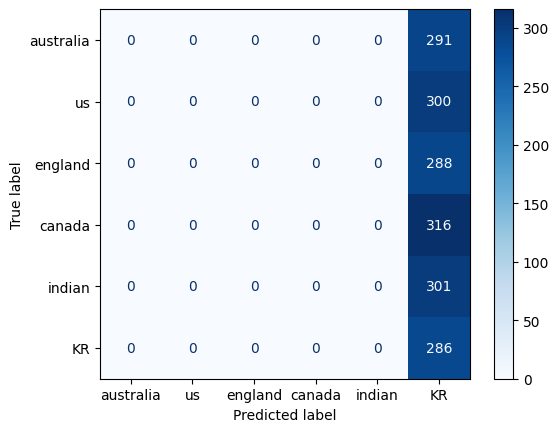

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

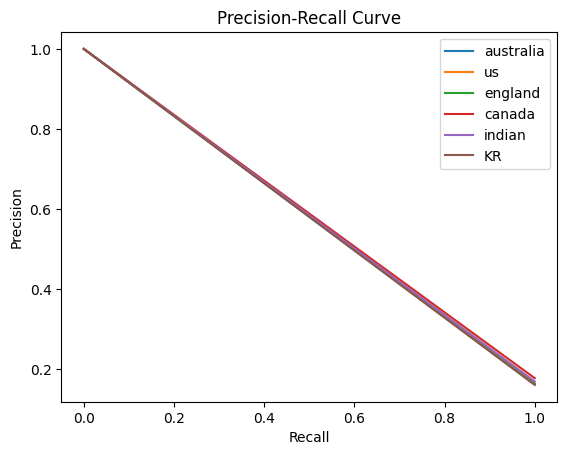

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, average_precision_score, precision_recall_curve
import pandas as pd
from google.colab import files

# 모델 로드 및 평가
model.load_state_dict(torch.load('/content/accent_rnn_model.pth'))
model.eval()

torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

all_preds = []
all_labels = []
all_indices = []
all_probs = []

with torch.no_grad():
    for idx, (log_mel_specs, labels) in enumerate(test_loader):
        log_mel_specs = log_mel_specs.to('cuda').float()
        labels = labels.to('cuda').long()

        outputs = model(log_mel_specs)
        probs = torch.softmax(outputs, dim=1)  # 클래스 확률 계산
        _, predicted = torch.max(outputs.data, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_indices.extend(range(idx * batch_size, idx * batch_size + len(labels)))

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate mAP for each class and macro average
all_probs_np = np.array(all_probs)
all_labels_np = np.array(all_labels)
mAPs = []

for i in range(len(accent_list)):
    mAP = average_precision_score(all_labels_np == i, all_probs_np[:, i])
    mAPs.append(mAP)
    print(f'Class {accent_list[i]} mAP: {mAP:.4f}')

macro_mAP = np.mean(mAPs)
print(f'Test macro mAP: {macro_mAP:.4f}')

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=accent_list)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 예측 결과를 엑셀로 저장
results_df = pd.DataFrame({
    'Index': all_indices,
    'True Label': [accent_list[label] for label in all_labels],
    'Predicted Label': [accent_list[pred] for pred in all_preds]
})

# 엑셀 파일로 저장
results_df.to_excel('/content/prediction_results.xlsx', index=False)

# 엑셀 파일 다운로드
files.download('/content/prediction_results.xlsx')

# Precision-Recall 곡선 시각화
for i in range(len(accent_list)):
    precision, recall, _ = precision_recall_curve(all_labels_np == i, all_probs_np[:, i])
    plt.plot(recall, precision, label=accent_list[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
